In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
sns.set_context(context='talk',font_scale=0.5)

In [5]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [6]:
# @title Data loading
alldata = np.array([])
for j in range(len(fname)):
  alldata = np.hstack((alldata,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

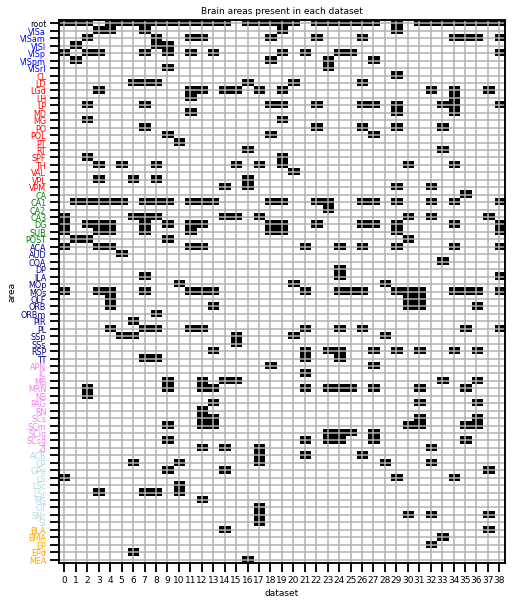

In [7]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldata)), dtype=bool)
for j, d in enumerate(alldata):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldata)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

In [ ]:
print(list(area_to_index.keys()))

['root', 'VISa', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl', 'CL', 'LD', 'LGd', 'LH', 'LP', 'MD', 'MG', 'PO', 'POL', 'PT', 'RT', 'SPF', 'TH', 'VAL', 'VPL', 'VPM', 'CA', 'CA1', 'CA2', 'CA3', 'DG', 'SUB', 'POST', 'ACA', 'AUD', 'COA', 'DP', 'ILA', 'MOp', 'MOs', 'OLF', 'ORB', 'ORBm', 'PIR', 'PL', 'SSp', 'SSs', 'RSP', 'TT', 'APN', 'IC', 'MB', 'MRN', 'NB', 'PAG', 'RN', 'SCs', 'SCm', 'SCig', 'SCsg', 'ZI', 'ACB', 'CP', 'GPe', 'LS', 'LSc', 'LSr', 'MS', 'OT', 'SNr', 'SI', 'BLA', 'BMA', 'EP', 'EPd', 'MEA']


In [ ]:
areas_by_dataset.shape

(73, 39)

### Reward encoding neurons (time window from -150ms to 0ms before reward feedback)

In [8]:
reg_list = list(area_to_index.keys()) #領域の名前73個

bin_wid = 15

nonzero_rewb_all = np.zeros(73) #各領野の非ゼロのニューロン数
neurons_all = np.zeros(73) #各領野のニューロンの合計数
nonzero_ind_rewb_all = np.zeros((39,1800)) #非ゼロのニューロンのインデックスを示す配列

acc_all = np.zeros((39,73))
acc_all = np.where(acc_all==0,np.nan,np.nan)

for n in range(39):
    if n % 5 == 0:
        print('繰り返し{}回目スタート'.format(str(n+1)))
    dat = alldata[n]
    dt = dat['bin_size']  # 0.01
    NT = dat['spks'].shape[-1] #250

    #ある特定の領野に注目
    for m in range(73):
        if areas_by_dataset[m,n] == True: #そのデータセットに領野のデータが存在するとき
            reg = reg_list[m]

            reg_ind = np.where(dat['brain_area']==reg)[0] #領野のインデックスを取り出す
            neurons_all[m] = neurons_all[m] + len(reg_ind) #ニューロン数を更新
            time_bin = np.arange(-500,2000,10)

            fb = np.round(dat['feedback_time'],2)*1000 #報酬がもらえた時間(10ミリ秒単位に直す)
            fb_ind_bin = np.zeros(fb.shape).astype(int).reshape(-1)
            for j in range(len(dat['feedback_time'])):
                if fb[j] < 2000:
                    fb_ind_bin[j] = np.where(time_bin == fb[j])[0]
                else:
                    fb_ind_bin[j] = 0
            tr_fb = np.where(fb_ind_bin != 0)[0] #2000ミリ秒以内にFBをもらっている試行の番号

            ##該当するニューロン×試行数×時系列の配列を取り出す
            spks = dat['spks'][reg_ind,:,:]
            fbtype = dat['feedback_type'][tr_fb] #FB：水かノイズ

            ##ニューロンそれぞれに対して特定の時間窓の内での発火頻度を算出，結果として試行数×ニューロン数の配列を得る
            #1試行ずつ特定の時間窓の発火頻度の時系列を取り出す
            spks_fet = np.zeros((np.sum(fb_ind_bin != 0),len(reg_ind)))
            s = 0
                    
            for k in range(len(dat['feedback_time'])):
                if fb_ind_bin[k] != 0 and len(reg_ind) > 0:
                    spks_fet[s,:] = np.mean(1/dt * spks[:,k,fb_ind_bin[k]-bin_wid:fb_ind_bin[k]],axis=1).reshape(1,len(reg_ind))
                    s = s + 1

            ##5分割交差検証により，トレーニングとテストに分けてロジスティック回帰(L1正則化)を実施
            kf = StratifiedKFold(n_splits=5, shuffle=True)
            best_C = np.zeros(5)
            acc = np.zeros(5)
            k = 0
            for train_ind, test_ind in kf.split(spks_fet,fbtype):
                X_train, X_test = spks_fet[train_ind,:], spks_fet[test_ind,:]
                Y_train, Y_test = fbtype[train_ind], fbtype[test_ind]

                #最適なハイパーパラメータ(正則化の強さ)を探す
                params = {'C': [10**(i/2) for i in range(-8,8)]}
                gs = GridSearchCV(LogisticRegression(penalty='l1',solver='liblinear'),param_grid=params,cv=5)
                gs.fit(X_train,Y_train)

                best_C[k] = gs.best_params_['C']
                acc[k] = gs.best_score_
                # print('Best Parameter(C) : {}'.format(gs.best_params_))
                # print('Best cross-validation score : {}'.format(gs.best_score_))
                k = k + 1

            acc_all[n,m] = np.max(acc)
            unique, freq = np.unique(best_C,return_counts=True)
            best_C = unique[np.argmax(freq)]

            #最適なパラメータとすべてのデータでモデル構築
            clf = LogisticRegression(penalty='l1',solver='liblinear',C=best_C,max_iter=300)
            clf.fit(spks_fet,fbtype)
            weight = clf.coef_
            nonzero_rewb_all[m] = nonzero_rewb_all[m] + np.sum(weight != 0) #非ゼロのニューロン数を更新
            nonzero_ind = np.where(weight != 0)[0]
            for p in range(len(weight)):
                nonzero_ind_rewb_all[n,reg_ind[p]] = 1


繰り返し1回目スタート
繰り返し6回目スタート
繰り返し11回目スタート
繰り返し16回目スタート
繰り返し21回目スタート
繰り返し26回目スタート
繰り返し31回目スタート
繰り返し36回目スタート


(0.0, 100.0)

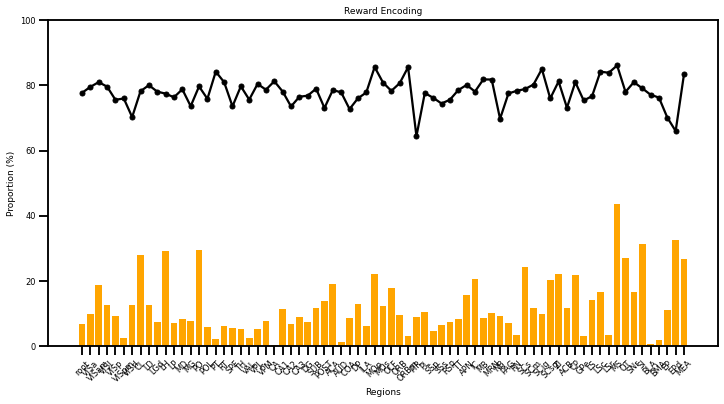

In [9]:
#比率のプロット
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(1,1,1)

ax.bar(np.arange(0,len(neurons_all),1),100 * nonzero_rewb_all / neurons_all,color='orange')
ax.plot(np.arange(0,len(neurons_all),1),np.nanmean(acc_all,axis=0)*100,marker='o',color='black',ms=5)

ax.set_xlabel('Regions')
ax.set_ylabel('Proportion (%)')
ax.set_xticks(np.arange(0,len(neurons_all)))
ax.set_xticklabels(reg_list,rotation=45)
ax.set_title('Reward Encoding')
ax.set_ylim(0,100)

In [10]:
nonzero_ind_rewb_all

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

### Reward encoding neurons (time window from 0ms to 250ms after reward feedback)

In [11]:
reg_list = list(area_to_index.keys()) #領域の名前73個

dt = dat['bin_size']  # 0.01
NT = dat['spks'].shape[-1] #250
bin_wid = 25

nonzero_rewa_all = np.zeros(73) #各領野の非ゼロのニューロン数
neurons_all = np.zeros(73) #各領野のニューロンの合計数
nonzero_ind_rewa_all = np.zeros((39,1800)) #非ゼロのニューロンのインデックスを示す配列

acc_all = np.zeros((39,73))
acc_all = np.where(acc_all==0,np.nan,np.nan)


for n in range(39):
    if n % 5 == 0:
        print('繰り返し{}回目スタート'.format(str(n+1)))
    dat = alldata[n]

    #ある特定の領野に注目
    for m in range(73):
        if areas_by_dataset[m,n] == True: #そのデータセットに領野のデータが存在するとき
            reg = reg_list[m]

            reg_ind = np.where(dat['brain_area']==reg)[0] #領野のインデックスを取り出す
            neurons_all[m] = neurons_all[m] + len(reg_ind) #ニューロン数を更新
            time_bin = np.arange(-500,2000,10)

            fb = np.round(dat['feedback_time'],2)*1000 #報酬がもらえた時間(10ミリ秒単位に直す)
            fb_ind_bin = np.zeros(fb.shape).astype(int).reshape(-1)
            for j in range(len(dat['feedback_time'])):
                if fb[j] < 2000:
                    fb_ind_bin[j] = np.where(time_bin == fb[j])[0]
                else:
                    fb_ind_bin[j] = 0
            tr_fb = np.where(fb_ind_bin != 0)[0] #2000ミリ秒以内にFBをもらっている試行の番号

            ##該当するニューロン×試行数×時系列の配列を取り出す
            spks = dat['spks'][reg_ind,:,:]
            fbtype = dat['feedback_type'][tr_fb] #FB：水かノイズ

            ##ニューロンそれぞれに対して特定の時間窓の内での発火頻度を算出，結果として試行数×ニューロン数の配列を得る
            #1試行ずつ特定の時間窓の発火頻度の時系列を取り出す
            spks_fet = np.zeros((np.sum(fb_ind_bin != 0),len(reg_ind)))
            s = 0
                    
            for k in range(len(dat['feedback_time'])):
                if fb_ind_bin[k] != 0 and len(reg_ind) > 0:
                    spks_fet[s,:] = np.mean(1/dt * spks[:,k,fb_ind_bin[k]:fb_ind_bin[k]+bin_wid],axis=1).reshape(1,len(reg_ind))
                    s = s + 1

            ##5分割交差検証により，トレーニングとテストに分けてロジスティック回帰(L1正則化)を実施
            kf = StratifiedKFold(n_splits=5, shuffle=True)
            best_C = np.zeros(5)
            acc = np.zeros(5)
            k = 0
            for train_ind, test_ind in kf.split(spks_fet,fbtype):
                X_train, X_test = spks_fet[train_ind,:], spks_fet[test_ind,:]
                Y_train, Y_test = fbtype[train_ind], fbtype[test_ind]

                #最適なハイパーパラメータ(正則化の強さ)を探す
                params = {'C': [10**(i/2) for i in range(-8,8)]}
                gs = GridSearchCV(LogisticRegression(penalty='l1',solver='liblinear'),param_grid=params,cv=5)
                gs.fit(X_train,Y_train)

                best_C[k] = gs.best_params_['C']
                acc[k] = gs.best_score_
                # print('Best Parameter(C) : {}'.format(gs.best_params_))
                # print('Best cross-validation score : {}'.format(gs.best_score_))
                k = k + 1

            acc_all[n,m] = np.max(acc)
            unique, freq = np.unique(best_C,return_counts=True)
            best_C = unique[np.argmax(freq)]

            #最適なパラメータとすべてのデータでモデル構築
            clf = LogisticRegression(penalty='l1',solver='liblinear',C=best_C,max_iter=300)
            clf.fit(spks_fet,fbtype)
            weight = clf.coef_
            nonzero_rewa_all[m] = nonzero_rewa_all[m] + np.sum(weight != 0) #非ゼロのニューロン数を更新
            nonzero_ind = np.where(weight != 0)[0]
            for p in range(len(weight)):
                nonzero_ind_rewa_all[n,reg_ind[p]] = 1


繰り返し1回目スタート
繰り返し6回目スタート
繰り返し11回目スタート
繰り返し16回目スタート
繰り返し21回目スタート
繰り返し26回目スタート
繰り返し31回目スタート
繰り返し36回目スタート


Text(0.5, 1.0, 'Reward Encoding')

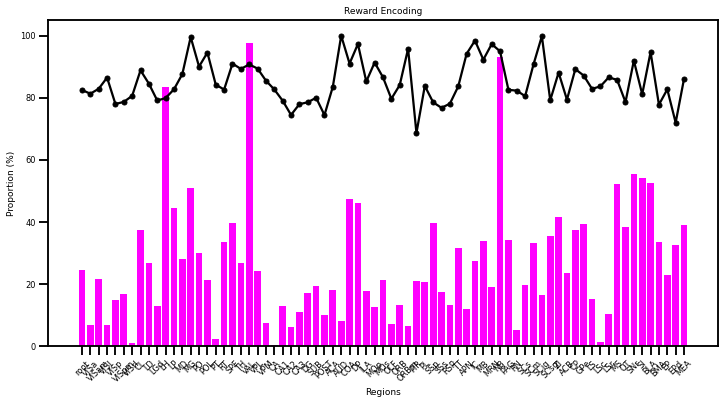

In [12]:
#比率のプロット
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(1,1,1)

ax.bar(np.arange(0,len(neurons_all),1),100 * nonzero_rewa_all / neurons_all,color='magenta')
ax.plot(np.arange(0,len(neurons_all),1),np.nanmean(acc_all,axis=0)*100,marker='o',color='black',ms=5)

ax.set_xlabel('Regions')
ax.set_ylabel('Proportion (%)')
ax.set_xticks(np.arange(0,len(neurons_all)))
ax.set_xticklabels(reg_list,rotation=45)
ax.set_title('Reward Encoding')
# ax.set_ylim(0,30)

In [13]:
nonzero_ind_rewa_all

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

### Choice encoding neurons (time window from -250ms to 0ms relative to motion onset)

In [14]:
reg_list = list(area_to_index.keys()) #領域の名前73個

dt = dat['bin_size']  # 0.01
NT = dat['spks'].shape[-1] #250
bin_wid = 25

nonzero_ch_all = np.zeros(73) #各領野の非ゼロのニューロン数
neurons_all = np.zeros(73) #各領野のニューロンの合計数
nonzero_ind_ch_all = np.zeros((39,1800)) #非ゼロのニューロンのインデックスを示す配列

acc_all = np.zeros((39,73))
acc_all = np.where(acc_all==0,np.nan,np.nan)

for n in range(39):
    if n % 5 == 0:
        print('繰り返し{}回目スタート'.format(str(n+1)))
    dat = alldata[n]

    #ある特定の領野に注目
    for m in range(73):
        if areas_by_dataset[m,n] == True: #そのデータセットに領野のデータが存在するとき
            reg = reg_list[m]

            reg_ind = np.where(dat['brain_area']==reg)[0] #領野のインデックスを取り出す
            neurons_all[m] = neurons_all[m] + len(reg_ind) #ニューロン数を更新
            time_bin = np.arange(-500,2000,10)

            rt = dat['reaction_time'][:,0]
            resp_bin = np.zeros(dat['response'].shape).astype(int) #反応した瞬間の時間ビンのインデックス
            for j in range(len(dat['response'])):
                if rt[j] != np.inf:
                    resp_bin[j] = np.where(time_bin == rt[j])[0]
                else:
                    resp_bin[j] = 0
            
            tr_go = np.where(dat['response']!=0)[0] #Goの試行番号だけ取り出す

            ##該当するニューロン×試行数×時系列の配列を取り出す
            spks = dat['spks'][reg_ind,:,:]
            chtype = dat['response'][tr_go]

            ##ニューロンそれぞれに対して特定の時間窓の内での発火頻度を算出，結果として試行数×ニューロン数の配列を得る
            #1試行ずつ特定の時間窓の発火頻度の時系列を取り出す
            spks_fet = np.zeros((len(tr_go),len(reg_ind)))
            s = 0
                    
            for k in range(len(dat['response'])):
                if resp_bin[k] != 0 and dat['response'][k] != 0 and len(reg_ind) > 0:
                    spks_fet[s,:] = np.mean(1/dt * spks[:,k,resp_bin[k]-bin_wid:resp_bin[k]],axis=1).reshape(1,len(reg_ind))
                    s = s + 1

            ##5分割交差検証により，トレーニングとテストに分けてロジスティック回帰(L1正則化)を実施
            kf = StratifiedKFold(n_splits=5, shuffle=True)
            best_C = np.zeros(5)
            acc = np.zeros(5)
            k = 0
            for train_ind, test_ind in kf.split(spks_fet,chtype):
                X_train, X_test = spks_fet[train_ind,:], spks_fet[test_ind,:]
                Y_train, Y_test = chtype[train_ind], chtype[test_ind]

                #最適なハイパーパラメータ(正則化の強さ)を探す
                params = {'C': [10**(i/2) for i in range(-8,8)]}
                gs = GridSearchCV(LogisticRegression(penalty='l1',solver='liblinear'),param_grid=params,cv=5)
                gs.fit(X_train,Y_train)

                best_C[k] = gs.best_params_['C']
                acc[k] = gs.best_score_
                # print('Best Parameter(C) : {}'.format(gs.best_params_))
                # print('Best cross-validation score : {}'.format(gs.best_score_))
                k = k + 1

            acc_all[n,m] = np.max(acc)
            unique, freq = np.unique(best_C,return_counts=True)
            best_C = unique[np.argmax(freq)]

            #最適なパラメータとすべてのデータでモデル構築
            clf = LogisticRegression(penalty='l1',solver='liblinear',C=best_C,max_iter=300)
            clf.fit(spks_fet,chtype)
            weight = clf.coef_
            nonzero_ch_all[m] = nonzero_ch_all[m] + np.sum(weight != 0) #非ゼロのニューロン数を更新
            nonzero_ind = np.where(weight != 0)[0]
            for p in range(len(weight)):
                nonzero_ind_ch_all[n,reg_ind[p]] = 1

繰り返し1回目スタート
繰り返し6回目スタート
繰り返し11回目スタート
繰り返し16回目スタート
繰り返し21回目スタート
繰り返し26回目スタート
繰り返し31回目スタート
繰り返し36回目スタート


Text(0.5, 1.0, 'Choice Encoding')

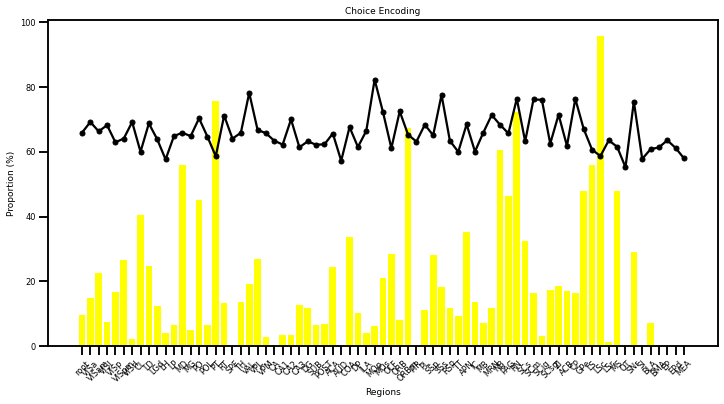

In [15]:
#比率のプロット
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(1,1,1)

ax.bar(np.arange(0,len(neurons_all),1),100 * nonzero_ch_all / neurons_all,color='yellow')
ax.plot(np.arange(0,len(neurons_all),1),np.nanmean(acc_all,axis=0)*100,marker='o',color='black',ms=5)

ax.set_xlabel('Regions')
ax.set_ylabel('Proportion (%)')
ax.set_xticks(np.arange(0,len(neurons_all)))
ax.set_xticklabels(reg_list,rotation=45)
ax.set_title('Choice Encoding')
# ax.set_ylim(0,30)

### Action encoding neurons (time window from -250ms to 0ms relative to motion onset)

In [29]:
reg_list = list(area_to_index.keys()) #領域の名前73個

dt = dat['bin_size']  # 0.01
NT = dat['spks'].shape[-1] #250
bin_wid = 15

nonzero_act_all = np.zeros(73) #各領野の非ゼロのニューロン数
neurons_all = np.zeros(73) #各領野のニューロンの合計数
nonzero_ind_act_all = np.zeros((39,1800)) #非ゼロのニューロンのインデックスを示す配列

acc_all = np.zeros((39,73))
acc_all = np.where(acc_all==0,np.nan,np.nan)

for n in range(39):
    if n % 5 == 0:
        print('繰り返し{}回目スタート'.format(str(n+1)))
    dat = alldata[n]

    #ある特定の領野に注目
    for m in range(73):
        if areas_by_dataset[m,n] == True: #そのデータセットに領野のデータが存在するとき
            reg = reg_list[m]

            reg_ind = np.where(dat['brain_area']==reg)[0] #領野のインデックスを取り出す
            neurons_all[m] = neurons_all[m] + len(reg_ind) #ニューロン数を更新
            time_bin = np.arange(-500,2000,10)

            rt = dat['reaction_time'][:,0]
            resp_bin = np.zeros(dat['response'].shape).astype(int) #反応した瞬間の時間ビンのインデックス
            for j in range(len(dat['response'])):
                if rt[j] != np.inf:
                    resp_bin[j] = np.where(time_bin == rt[j])[0]
                else:
                    resp_bin[j] = 0

            resp_bin_nonzero = resp_bin[np.where(resp_bin != 0)[0]]
            ave_rt = round(np.mean(resp_bin_nonzero),ndigits=-1).astype(int)
            ave_rt_bin = np.where(time_bin == ave_rt)[0]
            
            #GoとNo Goの2値にする
            actype= np.zeros(dat['response'].shape)
            for t in range(len(dat['response'])):
                if dat['response'][t] != 0: #動いていたら1にする
                    actype[t] = 1

            ##該当するニューロン×試行数×時系列の配列を取り出す
            spks = dat['spks'][reg_ind,:,:]

            ##ニューロンそれぞれに対して特定の時間窓の内での発火頻度を算出，結果として試行数×ニューロン数の配列を得る
            #1試行ずつ特定の時間窓の発火頻度の時系列を取り出す
            spks_fet = np.zeros((len(dat['response']),len(reg_ind)))
            s = 0
                    
            for k in range(len(dat['response'])):
                if len(reg_ind) > 0:
                    spks_fet[s,:] = np.mean(1/dt * spks[:,k,50:int(ave_rt_bin)],axis=1).reshape(1,len(reg_ind))
                    s = s + 1

            ##5分割交差検証により，トレーニングとテストに分けてロジスティック回帰(L1正則化)を実施
            kf = StratifiedKFold(n_splits=5, shuffle=True)
            best_C = np.zeros(5)
            acc = np.zeros(5)
            k = 0
            for train_ind, test_ind in kf.split(spks_fet,actype):
                X_train, X_test = spks_fet[train_ind,:], spks_fet[test_ind,:]
                Y_train, Y_test = actype[train_ind], actype[test_ind]

                #最適なハイパーパラメータ(正則化の強さ)を探す
                params = {'C': [10**(i/2) for i in range(-8,8)]}
                gs = GridSearchCV(LogisticRegression(penalty='l1',solver='liblinear'),param_grid=params,cv=5)
                gs.fit(X_train,Y_train)

                best_C[k] = gs.best_params_['C']
                acc[k] = gs.best_score_
                # print('Best Parameter(C) : {}'.format(gs.best_params_))
                # print('Best cross-validation score : {}'.format(gs.best_score_))
                k = k + 1

            acc_all[n,m] = np.max(acc)
            unique, freq = np.unique(best_C,return_counts=True)
            best_C = unique[np.argmax(freq)]

            #最適なパラメータとすべてのデータでモデル構築
            clf = LogisticRegression(penalty='l1',solver='liblinear',C=best_C,max_iter=300)
            clf.fit(spks_fet,actype)
            weight = clf.coef_
            nonzero_act_all[m] = nonzero_act_all[m] + np.sum(weight != 0) #非ゼロのニューロン数を更新
            nonzero_ind = np.where(weight != 0)[0]
            for p in range(len(weight)):
                nonzero_ind_act_all[n,reg_ind[p]] = 1

繰り返し1回目スタート
繰り返し6回目スタート
繰り返し11回目スタート
繰り返し16回目スタート
繰り返し21回目スタート
繰り返し26回目スタート
繰り返し31回目スタート
繰り返し36回目スタート


(0.0, 100.0)

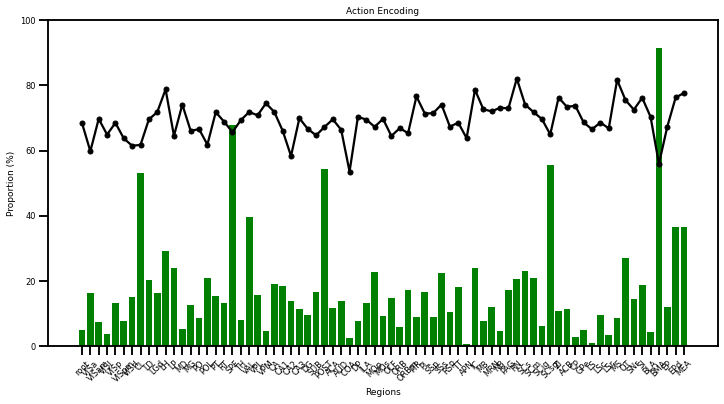

In [32]:
#比率のプロット
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(1,1,1)

ax.bar(np.arange(0,len(neurons_all),1),100 * nonzero_act_all / neurons_all,color='green')
ax.plot(np.arange(0,len(neurons_all),1),np.nanmean(acc_all,axis=0)*100,marker='o',color='black',ms=5)

ax.set_xlabel('Regions')
ax.set_ylabel('Proportion (%)')
ax.set_xticks(np.arange(0,len(neurons_all)))
ax.set_xticklabels(reg_list,rotation=45)
ax.set_title('Action Encoding')
ax.set_ylim(0,100)

### Vision encoding neurons (time window from 0ms to 400ms relative to stimlus onset)

In [57]:
reg_list = list(area_to_index.keys()) #領域の名前73個

dt = dat['bin_size']  # 0.01
NT = dat['spks'].shape[-1] #250
bin_wid = 15

nonzero_vis_all = np.zeros(73) #各領野の非ゼロのニューロン数
neurons_all = np.zeros(73) #各領野のニューロンの合計数
nonzero_ind_vis_all = np.zeros((39,1800)) #非ゼロのニューロンのインデックスを示す配列

acc_all = np.zeros((39,73))
acc_all = np.where(acc_all==0,np.nan,np.nan)

for n in range(39):
    if n % 5 == 0:
        print('繰り返し{}回目スタート'.format(str(n+1)))
    dat = alldata[n]

    #ある特定の領野に注目
    for m in range(73):
        if areas_by_dataset[m,n] == True: #そのデータセットに領野のデータが存在するとき
            reg = reg_list[m]

            reg_ind = np.where(dat['brain_area']==reg)[0] #領野のインデックスを取り出す
            neurons_all[m] = neurons_all[m] + len(reg_ind) #ニューロン数を更新
            time_bin = np.arange(-500,2000,10)

            # rt = dat['reaction_time'][:,0]
            # resp_bin = np.zeros(dat['response'].shape).astype(int) #反応した瞬間の時間ビンのインデックス
            # for j in range(len(dat['response'])):
            #     if rt[j] != np.inf:
            #         resp_bin[j] = np.where(time_bin == rt[j])[0]
            #     else:
            #         resp_bin[j] = 0
            
            #片方だけ提示されている試行のみに注目
            lis = []
            for t in range(len(dat['contrast_right'])):
                if (dat['contrast_right'][t] != 0 and dat['contrast_left'][t] == 0) or (dat['contrast_right'][t] == 0 and dat['contrast_left'][t] != 0):
                    lis.append(t)
            tr_uni = np.array(lis)

            stimtype = np.zeros(tr_uni.shape)
            s = 0
            for t in range(len(dat['contrast_right'])):
                if dat['contrast_right'][t] != 0 and dat['contrast_left'][t] == 0: #右に提示されている場合
                    stimtype[s] = -1
                    s = s + 1
                elif dat['contrast_right'][t] == 0 and dat['contrast_left'][t] != 0: #左に提示されている場合
                    stimtype[s] = 1
                    s = s + 1

            ##該当するニューロン×試行数×時系列の配列を取り出す
            spks = dat['spks'][reg_ind,:,:]

            ##ニューロンそれぞれに対して特定の時間窓の内での発火頻度を算出，結果として試行数×ニューロン数の配列を得る
            #1試行ずつ特定の時間窓の発火頻度の時系列を取り出す
            spks_fet = np.zeros((len(tr_uni),len(reg_ind)))
            s = 0
                    
            for k in range(len(tr_uni)):
                if len(reg_ind) > 0:
                    spks_fet[s,:] = np.mean(1/dt * spks[:,tr_uni[k],50:90],axis=1).reshape(1,len(reg_ind))
                    s = s + 1

            ##5分割交差検証により，トレーニングとテストに分けてロジスティック回帰(L1正則化)を実施
            kf = StratifiedKFold(n_splits=5, shuffle=True)
            best_C = np.zeros(5)
            acc = np.zeros(5)
            k = 0
            for train_ind, test_ind in kf.split(spks_fet,stimtype):
                X_train, X_test = spks_fet[train_ind,:], spks_fet[test_ind,:]
                Y_train, Y_test = stimtype[train_ind], stimtype[test_ind]

                #最適なハイパーパラメータ(正則化の強さ)を探す
                params = {'C': [10**(i/2) for i in range(-8,8)]}
                gs = GridSearchCV(LogisticRegression(penalty='l1',solver='liblinear'),param_grid=params,cv=5)
                gs.fit(X_train,Y_train)

                best_C[k] = gs.best_params_['C']
                acc[k] = gs.best_score_
                # print('Best Parameter(C) : {}'.format(gs.best_params_))
                # print('Best cross-validation score : {}'.format(gs.best_score_))
                # model = LogisticRegression(penalty='l1',solver='liblinear')
                # model.fit(X_train,Y_train)

                # acc[k] = model.score(X_test,Y_test)
                k = k + 1

            acc_all[n,m] = np.max(acc)
            unique, freq = np.unique(best_C,return_counts=True)
            best_C = unique[np.argmax(freq)]
            # best_C = 0.1

            #最適なパラメータとすべてのデータでモデル構築
            clf = LogisticRegression(penalty='l1',solver='liblinear',C=best_C,max_iter=300)
            clf.fit(spks_fet,stimtype)
            weight = clf.coef_
            nonzero_vis_all[m] = nonzero_vis_all[m] + np.sum(weight != 0) #非ゼロのニューロン数を更新
            nonzero_ind = np.where(weight != 0)[0]
            for p in range(len(weight)):
                nonzero_ind_vis_all[n,reg_ind[p]] = 1

繰り返し1回目スタート
繰り返し6回目スタート
繰り返し11回目スタート
繰り返し16回目スタート
繰り返し21回目スタート
繰り返し26回目スタート
繰り返し31回目スタート
繰り返し36回目スタート


Text(0.5, 1.0, 'Vision Encoding')

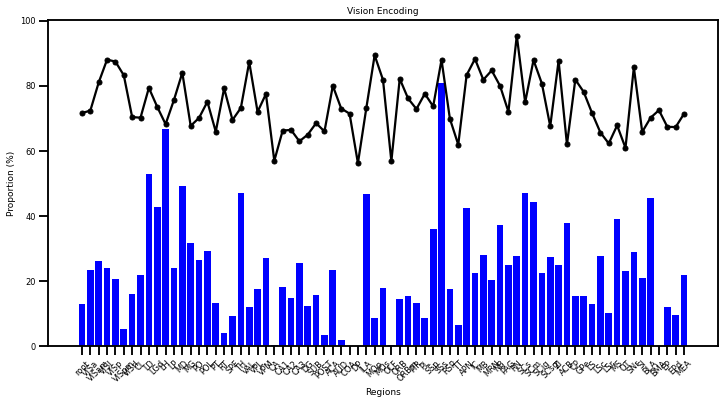

In [59]:
#重みと正答率のプロット
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(1,1,1)

ax.bar(np.arange(0,len(neurons_all),1),100 * nonzero_vis_all / neurons_all,color='blue')
ax.plot(np.arange(0,len(neurons_all),1),np.nanmean(acc_all,axis=0)*100,marker='o',color='black',ms=5)

ax.set_xlabel('Regions')
ax.set_ylabel('Proportion (%)')
ax.set_xticks(np.arange(0,len(neurons_all)))
ax.set_xticklabels(reg_list,rotation=45)
ax.set_title('Vision Encoding')
# ax.set_ylim(0,30)

(-0.029133720551867366, 0.029133720551867366)

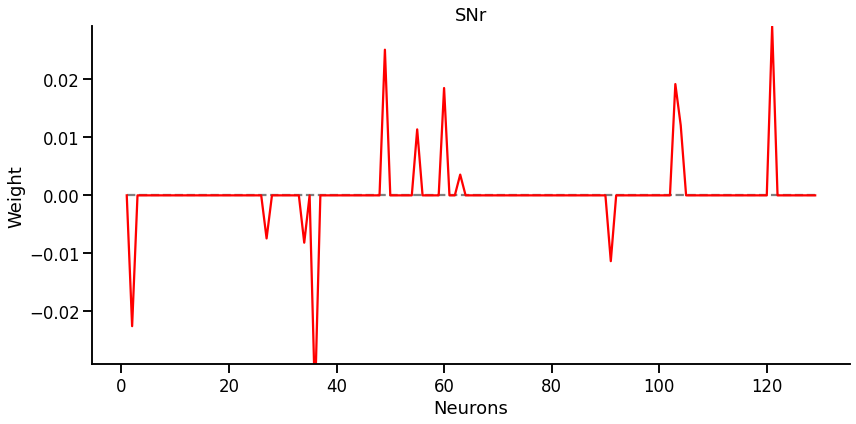

In [ ]:
#確率勾配で最適なハイパーパラメータ求める
def model_selection(X, y, C_values):
    """Compute CV accuracy for each C value.
    Args:
        X (2D array): Data matrix
        y (1D array): Label vector
        C_values (1D array): Array of hyperparameter values.
    Returns:
        accuracies (1D array): CV accuracy with each value of C.
    """
    accuracies = []
    for C in C_values:

        # Initialize and fit the model
        # (Hint, you may need to set max_iter)
        model = LogisticRegression(penalty="l1", solver='liblinear',C=C, max_iter=500)

        # Get the accuracy for each test split using cross-validation
        accs = cross_val_score(model, X, y, cv=5)

        # Store the average test accuracy for this value of C
        accuracies.append(accs.mean())

    return accuracies